# begin

In [ ]:
!pip install pyspark==3.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 18.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612229 sha256=a9477a47373e899166f8463902485a54ea93af6494bb98efc48ff5596e7adda4
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
! java --version

openjdk 11.0.19 2023-04-18
OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
import random

In [ ]:
# # Reading the input data
# import pandas as pd
# num_records = 40428967
# sample_size = 5000000
# skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
# parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

# train = pd.read_csv("/content/drive/MyDrive/data_ctr/train", parse_dates=['hour'], date_parser=parse_date,\
#                      skiprows=skip_values)

In [ ]:
# train.to_csv('/content/drive/MyDrive/data_ctr/train_cut.csv')

In [ ]:
# Tạo một phiên Spark mới
spark = SparkSession.builder.appName("CTR Prediction").getOrCreate()

In [ ]:
# num_records = 40428967
# sample_size = 10
# skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
schema = StructType([
    StructField("index", StringType(), True),
    StructField("id", StringType(), True),
    StructField("click", IntegerType(), True),
    StructField("hour", StringType(), True),
    StructField("C1", IntegerType(), True),
    StructField("banner_pos", IntegerType(), True),
    StructField("site_id", StringType(), True),
    StructField("site_domain", StringType(), True),
    StructField("site_category", StringType(), True),
    StructField("app_id", StringType(), True),
    StructField("app_domain", StringType(), True),
    StructField("app_category", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_ip", StringType(), True),
    StructField("device_model", StringType(), True),
    StructField("device_type", IntegerType(), True),
    StructField("device_conn_type", IntegerType(), True),
    StructField("C14", IntegerType(), True),
    StructField("C15", IntegerType(), True),
    StructField("C16", IntegerType(), True),
    StructField("C17", IntegerType(), True),
    StructField("C18", IntegerType(), True),
    StructField("C19", IntegerType(), True),
    StructField("C20", IntegerType(), True),
    StructField("C21", IntegerType(), True)
])

train = spark.read.csv(
    "/content/drive/MyDrive/data_ctr/train_cut.csv",
    header=True,
    schema=schema,
    timestampFormat="yyMMddHH",
    nullValue="")
    # mode="DROPMALFORMED")
# ).filter(~col("index").isin(skip_values))

In [ ]:
# schema = StructType([
#     StructField("id", StringType(), True),
#     StructField("hour", StringType(), True),
#     StructField("C1", IntegerType(), True),
#     StructField("banner_pos", IntegerType(), True),
#     StructField("site_id", StringType(), True),
#     StructField("site_domain", StringType(), True),
#     StructField("site_category", StringType(), True),
#     StructField("app_id", StringType(), True),
#     StructField("app_domain", StringType(), True),
#     StructField("app_category", StringType(), True),
#     StructField("device_id", StringType(), True),
#     StructField("device_ip", StringType(), True),
#     StructField("device_model", StringType(), True),
#     StructField("device_type", IntegerType(), True),
#     StructField("device_conn_type", IntegerType(), True),
#     StructField("C14", IntegerType(), True),
#     StructField("C15", IntegerType(), True),
#     StructField("C16", IntegerType(), True),
#     StructField("C17", IntegerType(), True),
#     StructField("C18", IntegerType(), True),
#     StructField("C19", IntegerType(), True),
#     StructField("C20", IntegerType(), True),
#     StructField("C21", IntegerType(), True)
# ])

# # test= spark.read.format("csv").option("header", "true").load("test.csv")
# test = spark.read.csv(
#     "/content/drive/MyDrive/data_ctr/test",
#     header=True,
#     schema=schema,
#     # timestampFormat="yyMMddHH",
#     nullValue="",
#     # mode="DROPMALFORMED"
# )

In [ ]:
# # # Đọc dữ liệu từ tập tin CSV và tạo một DataFrame
# # train = spark.read.format("csv").option("header", "true").load("train_cut.csv")

# test_1= spark.read.format("csv").option("header", "true").load("test.csv")

# Data preperation

In [ ]:
# tách cột hour ra 4 cột mới
from pyspark.sql.functions import month, dayofweek, dayofmonth, hour

train = train.withColumn("month", month("hour"))
train = train.withColumn("dayofweek", dayofweek("hour"))
train = train.withColumn("day", dayofmonth("hour"))
train = train.withColumn("hour_time", hour("hour"))
train.show(5)

+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|index|                  id|click|      hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|month|dayofweek|day|hour_time|
+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|    0|10000918755742328737|    0|2014-10-21|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| e6f67278|    be74e6fe|          1|               0|20632|320| 50|2374|  3| 39|  

In [ ]:
# dealing with outliers by capping
from pyspark.sql.functions import col, when

cols = ['C15', 'C16', 'C19', 'C21']
for col_name in cols:
    quantile_val = train.approxQuantile(col_name, [0.98], 0.25)[0]
    if quantile_val < 0.5 * train.select(col_name).rdd.max()[0]:
        train = train.withColumn(col_name, when(col(col_name) >= quantile_val, quantile_val).otherwise(col(col_name)))

train.show(5)

+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|index|                  id|click|      hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|month|dayofweek|day|hour_time|
+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|    0|10000918755742328737|    0|2014-10-21|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| e6f67278|    be74e6fe|          1|               0|20632|320| 50|2374|  3| 39|  

In [ ]:
# id column have a unique columns so, keeping that don't proive any significance,hence dropping.
# hour column have been derived into different columns, hence dropping.
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

from pyspark.sql.functions import col

train = train.drop("id").drop("hour").drop("index")
train = train.withColumnRenamed("click", "y").withColumnRenamed("hour_time", "hour")
train.show(5)

+---+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  y|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  0|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| e6f67278|    be74e6fe|          1|               0|20632|320| 50|2374|  3| 39|    -1| 23|
|  0|1005|         0|9e8cf15d|   0d3cb7be|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| 58811cdf|    8326c04b|          1|               2|20596|320| 50|2161|  0| 35|100148|157|
|  0|1005|         0|1fbe01fe|   f3845767|     289

# teslogistic regression
-> chia giữ liệu train test -> tạo pipeline

In [ ]:
# # function
# from pyspark.sql import functions as F
# def target_mean_encoding(df, col, target):
#     """
#     :param df: pyspark.sql.dataframe
#         dataframe to apply target mean encoding
#     :param col: str list
#         list of columns to apply target encoding
#     :param target: str
#         target column
#     :return:
#         dataframe with target encoded columns
#     """
#     target_encoded_columns_list = []
#     for c in col:
#         print(c)
#         means = df.groupby(F.col(c)).agg(F.mean(target).alias(f"{c}_mean_encoding"))
#         dict_ = means.toPandas().to_dict()
#         target_encoded_columns = [F.when(F.col(c) == v, encoder)
#                                   for v, encoder in zip(dict_[c].values(),
#                                                         dict_[f"{c}_mean_encoding"].values())]
#         target_encoded_columns_list.append(F.coalesce(*target_encoded_columns).alias(f"{c}_mean_encoding"))
#     return df.select(target, *target_encoded_columns_list)


In [ ]:
# # chọn thuộc tính + encode, bỏ 'device_id'
# #'site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model'
# df_target_encoded = target_mean_encoding(train_test_1, col=['site_id','site_domain','site_category','app_id','app_domain','app_category','device_model'],
#                                           target='y')

In [ ]:
"""
Lấy mẫu dữ liệu 10% trên 5tr dòng
Ex code:
# Load your data into a PySpark dataframe
df = spark.read.csv("your_data.csv", header=True, inferSchema=True)

# Randomly sample 5000 rows from the dataframe
df_sample = df.sample(withReplacement=False, fraction=5000/df.count(), seed=123)

# Show the first 10 rows of the sampled dataframe
df_sample.show(10)

"""
sampled_data = train.sample(fraction=0.25, seed=42)
# # X = sampled_data.drop("y")
# # y = sampled_data.select("y")

In [ ]:
train

DataFrame[index: string, id: string, click: int, hour: string, C1: int, banner_pos: int, site_id: string, site_domain: string, site_category: string, app_id: string, app_domain: string, app_category: string, device_id: string, device_ip: string, device_model: string, device_type: int, device_conn_type: int, C14: int, C15: int, C16: int, C17: int, C18: int, C19: int, C20: int, C21: int]

+---+-------+---------+
|  y|  count|    ratio|
+---+-------+---------+
|  1| 850412|0.1700824|
|  0|4149588|0.8299176|
+---+-------+---------+



<Figure size 640x480 with 0 Axes>

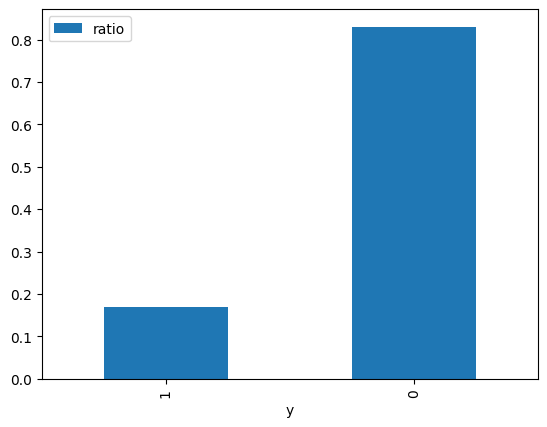

In [ ]:
import matplotlib.pyplot as plt

output_dist = train.groupBy("y").count().withColumn("ratio", col("count") / train.count())
output_dist.show()
plt.figure()
output_dist.toPandas().plot(kind="bar", x="y", y="ratio")
plt.show()

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 70:30
(trainingData, testData) = sampled_data.randomSplit([0.7, 0.3], seed=1234)

In [ ]:

#Write DataFrame to CSV file
testData.write.csv("/content/drive/MyDrive/data_ctr/testData")

+---+------+-------------------+
|  y| count|              ratio|
+---+------+-------------------+
|  1|149125|0.17010003536027557|
|  0|727565| 0.8298999646397244|
+---+------+-------------------+



<Figure size 640x480 with 0 Axes>

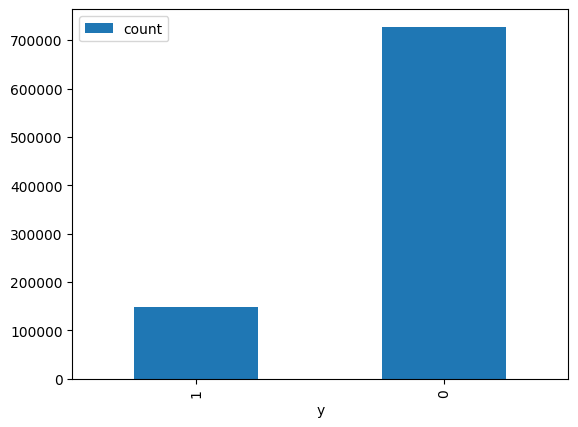

In [ ]:
import matplotlib.pyplot as plt

output_dist = trainingData.groupBy("y").count().withColumn("ratio", col("count") / trainingData.count())
output_dist.show()
plt.figure()
output_dist.toPandas().plot(kind="bar", x="y", y="count")
plt.show()

+---+------+-------------------+
|  y| count|              ratio|
+---+------+-------------------+
|  1| 63694|0.16982213654772665|
|  0|311369| 0.8301778634522734|
+---+------+-------------------+



<Figure size 640x480 with 0 Axes>

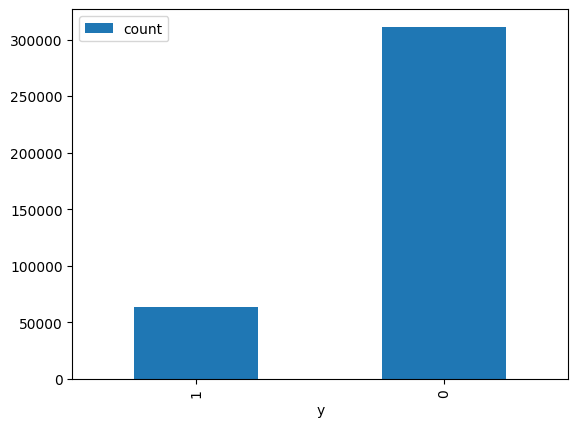

In [ ]:
import matplotlib.pyplot as plt

output_dist = testData.groupBy("y").count().withColumn("ratio", col("count") / testData.count())
output_dist.show()
plt.figure()
output_dist.toPandas().plot(kind="bar", x="y", y="count")
plt.show()

In [ ]:
# tạo pipeline luôn

In [ ]:
list_features = ['site_domain','site_id','app_category','app_domain'
,'site_category','C16','C21','app_id'
,'C18','device_type','banner_pos','device_model'
,'device_conn_type','C17','device_id','C19']

In [ ]:
from pyspark.ml.feature import StringIndexer
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in {'site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model'})]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in list_features)]

In [ ]:
from pyspark.ml.feature import OneHotEncoder
ohe = [OneHotEncoder(inputCol=column + '_index', outputCol=column+"_index_ohe",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in list_features)]

In [ ]:
assembler = VectorAssembler(inputCols=[col + '_index_ohe' for col in list_features], outputCol="features")

In [ ]:
from pyspark.ml.feature import MinMaxScaler
scalers = MinMaxScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
lr = LogisticRegression(labelCol="y", featuresCol="features_scaled")

In [ ]:
pipeline = Pipeline(stages= indexers + ohe + [assembler,scalers, lr])

In [ ]:
# # old
# # Huấn luyện pipeline trên tập huấn luyện
# model = pipeline.fit(trainingData)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Trains a model with CrossValidator
paramGrid = ParamGridBuilder() \
        .addGrid(lr.threshold, [0.22]) \
        .addGrid(lr.elasticNetParam, [0.0]) \
        .addGrid(lr.regParam, [0.001]) \
        .addGrid(lr.maxIter, [100]) \
        .build()

cv = CrossValidator(estimator=pipeline,
                        evaluator=BinaryClassificationEvaluator(labelCol = 'y'),
                        estimatorParamMaps=paramGrid,
                        numFolds=3)

cvModel = cv.fit(trainingData)

In [ ]:
cvModel.write().overwrite().save('/content/drive/MyDrive/data_ctr/model_logictic_imbalanced_with_fearture_eng_and_cross_train/')

In [ ]:
predictions = cvModel.transform(testData)

In [ ]:
confusionMatrix = predictions.select("y", "prediction") \
    .rdd.map(lambda x: (x[1], x[0])) \
    .countByValue()

In [ ]:
truePositive = confusionMatrix[(1, 1)]
falsePositive = confusionMatrix[(1, 0)]
trueNegative = confusionMatrix[(0, 0)]
falseNegative = confusionMatrix[(0, 1)]

# Tính toán precision, recall và F1-score
precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)
f1Score = 2 * precision * recall / (precision + recall)

print("Confusion Matrix:")
print("True Positive: ", truePositive)
print("False Positive: ", falsePositive)
print("True Negative: ", trueNegative)
print("False Negative: ", falseNegative)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1Score)

Confusion Matrix:
True Positive:  13236
False Positive:  28817
True Negative:  95636
False Negative:  11988
Precision:  0.314745678072908
Recall:  0.5247383444338725
F1-Score:  0.39347771155075284


Kết luận: Kết quả của mình tệ hợn có thể đến từ các yếu tố sau
+ Bộ encoder khác nhau
+ Chưa Standard Scaler
+ Đang Train ít dữ liệu

Lưu ý:
+ Mỗi mần chạy thuật toán mới thì sẽ tạo ra X_train X_test riêng (theo tác giả) rồi mới làm các bước chuẩn hóa sau ví dụ StandardScaler

Bài được combine 2 source

# Dessision Tree

In [ ]:
"""
Lấy mẫu dữ liệu 10% trên 5tr dòng
Ex code:
# Load your data into a PySpark dataframe
df = spark.read.csv("your_data.csv", header=True, inferSchema=True)

# Randomly sample 5000 rows from the dataframe
df_sample = df.sample(withReplacement=False, fraction=5000/df.count(), seed=123)

# Show the first 10 rows of the sampled dataframe
df_sample.show(10)

"""
sampled_data = train.sample(fraction=0.05, seed=42)
# # X = sampled_data.drop("y")
# # y = sampled_data.select("y")

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 70:30
(trainingData, testData) = sampled_data.randomSplit([0.7, 0.3], seed=1234)

In [ ]:
list_features = [
    'device_id', 'device_model',
    'hour', 'site_id',
    'app_id', 'day',
    'dayofweek', 'C17'
]

In [ ]:
from pyspark.ml.feature import StringIndexer
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in {'site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model'})]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in list_features)]

In [ ]:
from pyspark.ml.feature import OneHotEncoder
ohe = [OneHotEncoder(inputCol=column + '_index', outputCol=column+"_index_ohe",).setHandleInvalid("keep") for column in list(x for x in set(train.columns) if x in list_features)]

In [ ]:
assembler = VectorAssembler(inputCols=[col + '_index_ohe' for col in list_features], outputCol="features")

In [ ]:
from pyspark.ml.feature import MinMaxScaler
scalers = MinMaxScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dtree = DecisionTreeClassifier(labelCol="y", featuresCol="features_scaled")

In [ ]:
pipeline = Pipeline(stages= indexers + ohe + [assembler,scalers, dtree])

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Trains a model with CrossValidator
paramGrid = ParamGridBuilder() \
        .addGrid(dtree.maxDepth, [14]) \
        .build()
        # .addGrid(dtree.thresholds, dtree.setThresholds([0.22])) \
cv_dtree = CrossValidator(estimator=pipeline,
                        evaluator=BinaryClassificationEvaluator(labelCol = 'y'),
                        estimatorParamMaps=paramGrid,
                        numFolds=3)

cvModel = cv_dtree.fit(trainingData)

In [ ]:
cvModel.write().overwrite().save('/content/drive/MyDrive/data_ctr/model_dtree_2_imbalanced_with_fearture_eng_and_cross_train/')

In [ ]:
predictions = cvModel.transform(testData)
confusionMatrix = predictions.select("y", "prediction") \
    .rdd.map(lambda x: (x[1], x[0])) \
    .countByValue()
truePositive = confusionMatrix[(1, 1)]
falsePositive = confusionMatrix[(1, 0)]
trueNegative = confusionMatrix[(0, 0)]
falseNegative = confusionMatrix[(0, 1)]

# Tính toán precision, recall và F1-score
precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)
f1Score = 2 * precision * recall / (precision + recall)

print("Confusion Matrix:")
print("True Positive: ", truePositive)
print("False Positive: ", falsePositive)
print("True Negative: ", trueNegative)
print("False Negative: ", falseNegative)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1Score)

Confusion Matrix:
True Positive:  726
False Positive:  597
True Negative:  61722
False Negative:  12009
Precision:  0.5487528344671202
Recall:  0.05700824499411072
F1-Score:  0.10328638497652581
